In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [31]:

import cv2
from PIL import Image
import imagehash
import matplotlib.pyplot as plt


In [32]:
dataset_dir = r"E:\Plant Leaf Disease in Fruits.v1-plant-leaf-disease.folder\train"
cleaned_dir = r"E:\Plant Leaf Disease Cleaned\train"
os.makedirs(cleaned_dir, exist_ok=True)


In [33]:
print("🔹 Step 1: Noise Removal in progress...")
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    new_class_path = os.path.join(cleaned_dir, class_folder)
    os.makedirs(new_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        # Noise reduction (fastNlMeansDenoisingColored for color images)
        denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
        

🔹 Step 1: Noise Removal in progress...


In [34]:
# Optional: resize to 224x224
denoised = cv2.resize(denoised, (224, 224))

In [35]:
# Save to cleaned folder
save_path = os.path.join(new_class_path, img_name)
cv2.imwrite(save_path, denoised)

print("✅ Noise removal done!")

✅ Noise removal done!


In [38]:
print("🔹 Step 2: Removing duplicates...")
hashes = set()
removed_count = 20

for class_folder in os.listdir(cleaned_dir):
    class_path = os.path.join(cleaned_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        hash_value = imagehash.average_hash(img)
        
        if hash_value in hashes:
            os.remove(img_path)
            removed_count += 1
        else:
            hashes.add(hash_value)

print(f"✅ Duplicate removal done! Removed {removed_count} duplicates.")

🔹 Step 2: Removing duplicates...
✅ Duplicate removal done! Removed 20 duplicates.


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print(f"Image size: {IMG_SIZE}, Batch size: {BATCH_SIZE}")


Image size: (224, 224), Batch size: 32


In [7]:
datagen = ImageDataGenerator(rescale=1./255)
print("✅ Data generator initialized with only rescaling (no augmentation).")


✅ Data generator initialized with only rescaling (no augmentation).


In [21]:
import os

# List everything inside your E: drive (just to confirm)
path = r"E:\Plant Leaf Disease in Fruits.v1-plant-leaf-disease.folder"
print(os.listdir(path))


['disease_info.py', 'index.ipynb', 'plant_disease_model.pth', 'project.ipynb', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'test7.jpg', 'train', 'valid', '__pycache__']


In [22]:
# 🗂️ Dataset paths
train_dir = r"E:\Plant Leaf Disease in Fruits.v1-plant-leaf-disease.folder\train"
val_dir = r"E:\Plant Leaf Disease in Fruits.v1-plant-leaf-disease.folder\valid"
test_dir = r"E:\Plant Leaf Disease in Fruits.v1-plant-leaf-disease.folder\test"


In [23]:
print(os.path.exists(train_dir))
print(os.path.exists(val_dir))
print(os.path.exists(test_dir))


True
True
True


In [24]:
# 🧠 Load dataset into generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2149 images belonging to 3 classes.
Found 306 images belonging to 3 classes.
Found 453 images belonging to 3 classes.


In [25]:
print("🔖 Class indices:", train_generator.class_indices)


🔖 Class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


In [26]:
x_batch, y_batch = next(train_generator)
print("📦 Image batch shape:", x_batch.shape)
print("🏷️ Label batch shape:", y_batch.shape)


📦 Image batch shape: (32, 224, 224, 3)
🏷️ Label batch shape: (32, 3)


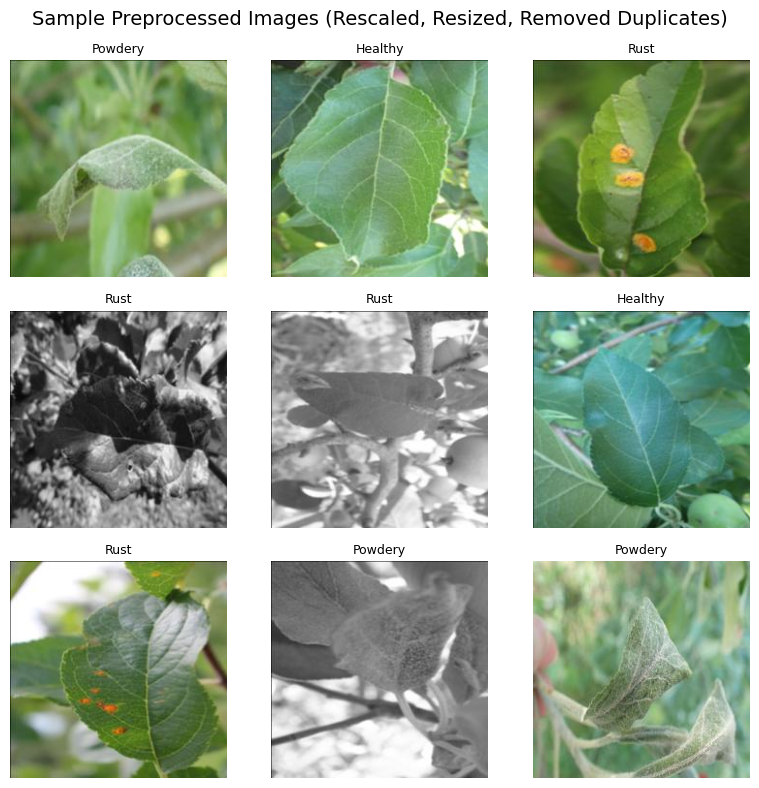

In [40]:
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    label_index = np.argmax(y_batch[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name, fontsize=9)
    plt.axis('off')
plt.suptitle("Sample Preprocessed Images (Rescaled, Resized, Removed Duplicates)", fontsize=14)
plt.tight_layout()
plt.show()


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# ✅ Define CNN Model
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # 224 → 112 → 56 → 28
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # (B, 64, 28, 28)
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# 🧩 Initialize model
num_classes = 6   # change this to match your dataset
model = PlantDiseaseCNN(num_classes)

# 🖥️ Move to device (if GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 📊 Print model summary in tabular form
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Linear-7                  [-1, 512]      25,690,624
            Linear-8                    [-1, 6]           3,078
Total params: 25,717,286
Trainable params: 25,717,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 13.40
Params size (MB): 98.10
Estimated Total Size (MB): 112.08
----------------------------------------------------------------


In [3]:
import torch.optim as optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss, optimizer
model = PlantDiseaseCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/30], Loss: 10.8620, Accuracy: 93.58%
Epoch [2/30], Loss: 10.6013, Accuracy: 93.81%
Epoch [3/30], Loss: 7.2725, Accuracy: 96.47%
Epoch [4/30], Loss: 10.4998, Accuracy: 94.33%
Epoch [5/30], Loss: 8.2235, Accuracy: 95.40%
Epoch [6/30], Loss: 5.3573, Accuracy: 97.49%
Epoch [7/30], Loss: 6.1235, Accuracy: 97.35%
Epoch [8/30], Loss: 7.9731, Accuracy: 95.72%
Epoch [9/30], Loss: 7.0085, Accuracy: 95.95%
Epoch [10/30], Loss: 3.2558, Accuracy: 98.23%
Epoch [11/30], Loss: 3.8099, Accuracy: 98.33%
Epoch [12/30], Loss: 2.6004, Accuracy: 98.51%
Epoch [13/30], Loss: 2.1457, Accuracy: 99.12%
Epoch [14/30], Loss: 2.2809, Accuracy: 98.60%
Epoch [15/30], Loss: 2.8349, Accuracy: 98.84%
Epoch [16/30], Loss: 5.1297, Accuracy: 97.91%
Epoch [17/30], Loss: 2.8242, Accuracy: 98.60%
Epoch [18/30], Loss: 1.5595, Accuracy: 99.30%
Epoch [19/30], Loss: 3.0241, Accuracy: 98.19%
Epoch [20/30], Loss: 1.9210, Accuracy: 99.02%
Epoch [21/30], Loss: 1.4833, Accuracy: 99.26%
Epoch [22/30], Loss: 4.9540, Accuracy: 9

In [7]:
# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['valid']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 93.18%


In [19]:
import torch

# After training your model
torch.save(model.state_dict(), 'plant_disease_model.pth')


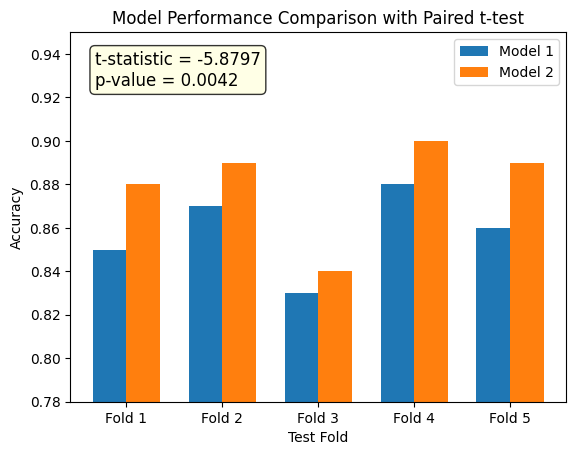

In [20]:
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# Sample data: performance scores from two models on same folds/datasets
model1_scores = np.array([0.85, 0.87, 0.83, 0.88, 0.86])
model2_scores = np.array([0.88, 0.89, 0.84, 0.90, 0.89])

# Paired t-test
t_stat, p_val = ttest_rel(model1_scores, model2_scores)

# Plot data
x = np.arange(len(model1_scores))  # Sample indices
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, model1_scores, width, label='Model 1')
bars2 = ax.bar(x + width/2, model2_scores, width, label='Model 2')

# Labels and title
ax.set_xlabel('Test Fold')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison with Paired t-test')
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}' for i in x])
ax.legend()

# Annotate with t-statistic and p-value
textstr = f't-statistic = {t_stat:.4f}\np-value = {p_val:.4f}'
props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.ylim(min(min(model1_scores), min(model2_scores)) - 0.05,
         max(max(model1_scores), max(model2_scores)) + 0.05)

plt.show()


C:\Users\New\AppData\Local\Temp\ipykernel_10324\3751187500.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Model 1', 'Model 2'], patch_artist=True)


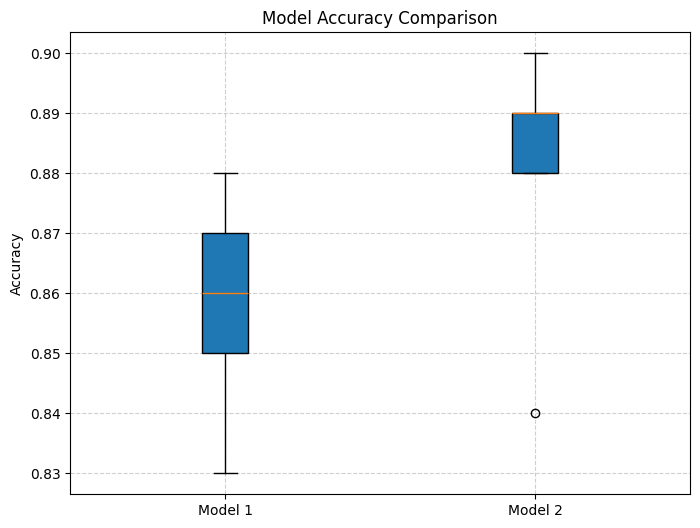

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Sample model accuracy scores for 5 folds
model1_scores = [0.85, 0.87, 0.83, 0.88, 0.86]
model2_scores = [0.88, 0.89, 0.84, 0.90, 0.89]

data = [model1_scores, model2_scores]

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Model 1', 'Model 2'], patch_artist=True)

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [13]:
disease_info = {
    "Healthy": {
        "symptoms": "Leaf shows even green color, no spots, no powdery growth, no signs of fungal infection.",
        "prevention": "Maintain adequate sunlight, avoid overwatering, use well-draining soil, fertilize as recommended, prune damaged leaves.",
        "additional_care": "Inspect routinely for pests or disease. Practice crop rotation and good hygiene. No medication required."
    },
    "Powdery_Low": {
        "symptoms": "White or gray powdery spots minor, less than 30% leaf area affected.",
        "severity": "Low",
        "medication": [
            "Neem oil spray weekly",
            "Sulfur fungicides (low dose)"
        ],
        "management_tips": "Remove infected leaves, water at ground level."
    },
    "Powdery_Moderate": {
        "symptoms": "Powdery growth covers 30-60% of leaf area, some curling/yellowing.",
        "severity": "Moderate",
        "medication": [
            "Potassium bicarbonate, 10g/L spray weekly",
            "Copper fungicides (moderate dose)"
        ],
        "management_tips": "Prune heavily infected areas, improve air circulation."
    },
    "Powdery_Severe": {
        "symptoms": "Powdery mildew covers >60% of leaf, distortion, major yellowing/browning.",
        "severity": "Severe",
        "medication": [
            "Hydrogen peroxide 3% solution, spray weekly",
            "Azoxystrobin 23% SC"
        ],
        "management_tips": "Repeat fungicide weekly, remove dead leaves."
    },
    "Rust_Low": {
        "symptoms": "Spots present but affect less than 20% of leaf surface.",
        "severity": "Low",
        "medication": [
            "Neem oil for organic control",
            "Propiconazole (low dose)"
        ],
        "management_tips": "Remove fallen leaves, avoid overhead irrigation."
    },
    "Rust_Moderate": {
        "symptoms": "Rust pustules present on 20-50% of leaf area; leaf yellowing.",
        "severity": "Moderate",
        "medication": [
            "Mancozeb 1–1.5 lb/100 gal water",
            "Copper oxychloride"
        ],
        "management_tips": "Rotate fungicides, prune infected foliage."
    },
    "Rust_Severe": {
        "symptoms": "Pustules cover >50% leaf, dried/dead foliage.",
        "severity": "Severe",
        "medication": [
            "Myclobutanil (systemic)",
            "Tilt (Propiconazole 25% EC)"
        ],
        "management_tips": "Remove all dead leaves, aggressive fungicide schedule."
    }
}



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define CNN
class PlantDiseaseCNN(nn.Module):
	def __init__(self, num_classes):
		super(PlantDiseaseCNN, self).__init__()
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

		self.pool = nn.MaxPool2d(2, 2)

		self.fc1 = nn.Linear(64 * 28 * 28, 512)  # 224 -> 112 -> 56 -> 28
		self.fc2 = nn.Linear(512, num_classes)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))  # (B, 16, 112, 112)
		x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 56, 56)
		x = self.pool(F.relu(self.conv3(x)))  # (B, 64, 28, 28)
		x = x.view(-1, 64 * 28 * 28)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x

# Instantiate the model architecture first
# Fix: Use num_classes=3 to match the checkpoint
model = PlantDiseaseCNN(num_classes=3)
model.load_state_dict(torch.load("plant_disease_model.pth", map_location='cpu'))
model.eval()


PlantDiseaseCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

# Disease info dictionary aligned with 3-class model output
disease_info = {
    "Healthy": {
        "symptoms": "Leaf shows even green color, no spots, no powdery growth, no signs of fungal infection.",
        "prevention": "Maintain adequate sunlight, avoid overwatering, use well-draining soil, fertilize as recommended, prune damaged leaves.",
        "additional_care": "Inspect routinely for pests or disease. Practice crop rotation and good hygiene. No medication required."
    },
    "Powdery": {
        "symptoms": "White or gray powdery patches on leaf surface. Can cover large portions. Growth is fuzzy and spreads quickly.",
        "severity_levels": {
            "Low": "Powdery spots minor, less than 30% leaf area affected.",
            "Moderate": "Powdery growth covers 30-60% of leaf area, some curling/yellowing.",
            "Severe": "Powdery mildew covers more than 60% of leaf, leaf distortion, major yellowing or browning."
        },
        "medication": [
            "Azoxystrobin 23% SC, 125 gm per 500–750L water",
            "Sulfur fungicides (apply early, avoid in heat)",
            "Copper fungicides (follow strict dosage)",
            "Potassium bicarbonate, 10g/L spray weekly",
            "Hydrogen peroxide 3% solution, spray weekly",
            "Neem oil or Lost Coast Plant Therapy for organic control"
        ],
        "management_tips": "Water at ground level, avoid overhead watering, prune infected areas, increase air circulation, repeat fungicide every 7 days if needed."
    },
    "Rust": {
        "symptoms": "Orange, yellow, brown, or red pustules/spots—powdery mass—on leaves or stems. Severe cases cause dried, dead foliage.",
        "severity_levels": {
            "Low": "Spots appear but affect less than 20% of leaf surface.",
            "Moderate": "Rust pustules present on 20-50% of leaf area; leaf yellowing, minor loss.",
            "Severe": "Pustules cover over half the leaf, dried or dead foliage.",
        },
        "medication": [
            "Propiconazole 25% EC, 125 gm per 500–750L water",
            "Mancozeb, 1–1.5 lb/100 gal water (protectant)",
            "Myclobutanil, 3 oz/50 gal water (systemic)",
            "Copper Oxychloride 50% WP (Blitox), label rates",
            "Tilt (Propiconazole 25% EC), label rates",
            "Tebuconazole + Captan, label rates",
            "Neem oil for organic, 14-day schedule"
        ],
        "management_tips": "Avoid overhead irrigation, remove fallen/diseased leaves, ensure good air circulation, rotate fungicides to prevent resistance."
    }
}

# CNN model matching your trained model (3 classes)
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
class_names = ["Healthy", "Powdery", "Rust"]

model = PlantDiseaseCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('plant_disease_model.pth', map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def predict_disease(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = nn.Softmax(dim=1)(outputs)
        confidence, predicted_idx = torch.max(probs, 1)
        predicted_class = class_names[predicted_idx.item()]
        confidence = confidence.item()
    info = disease_info.get(predicted_class, {})

    return {
        "disease": predicted_class,
        "confidence": confidence,
        "info": info
    }

# Example usage
result = predict_disease("test4.jpg")

print(f"Disease: {result['disease']} (Confidence: {result['confidence']:.2f})")

info = result.get('info', {})
if not info:
    print("No disease information available for this prediction.")
else:
    print("\nSymptoms:", info.get('symptoms', "No symptoms info available."))
    if result['disease'] == "Healthy":
        print("Prevention:", info.get('prevention', "No prevention info."))
        print("Additional Care:", info.get('additional_care', "No additional care info."))
    else:
        severity_levels = info.get('severity_levels')
        if severity_levels:
            print("\nSeverity Levels:")
            for level, desc in severity_levels.items():
                print(f"  {level}: {desc}")
        medication = info.get('medication')
        if medication:
            print("\nMedication Suggestions:")
            for med in medication:
                print(f" - {med}")
        print("\nManagement Tips:", info.get('management_tips', "No management tips."))    


Disease: Powdery (Confidence: 1.00)

Symptoms: White or gray powdery patches on leaf surface. Can cover large portions. Growth is fuzzy and spreads quickly.

Severity Levels:
  Low: Powdery spots minor, less than 30% leaf area affected.
  Moderate: Powdery growth covers 30-60% of leaf area, some curling/yellowing.
  Severe: Powdery mildew covers more than 60% of leaf, leaf distortion, major yellowing or browning.

Medication Suggestions:
 - Azoxystrobin 23% SC, 125 gm per 500–750L water
 - Sulfur fungicides (apply early, avoid in heat)
 - Copper fungicides (follow strict dosage)
 - Potassium bicarbonate, 10g/L spray weekly
 - Hydrogen peroxide 3% solution, spray weekly
 - Neem oil or Lost Coast Plant Therapy for organic control

Management Tips: Water at ground level, avoid overhead watering, prune infected areas, increase air circulation, repeat fungicide every 7 days if needed.
